In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# Paramètres de simulation
start_date_experimentation = '2020-01-01'
#end_date_experimentation = '2025-12-03'
risk_free_rate = 0.03 # Taux sans risque, 3% dans notre exemple
nb_simulation = 100
ticker = input("Entrez le ticker de l'action (par ex. AAPL, MSFT, TSLA) : ").strip().upper()

In [66]:
# Téléchargement des prix de clôture
prices = yf.download(ticker, start=start_date_experimentation)[['Close']]

if prices.empty:
    raise ValueError(f"Aucune donnée disponible pour {ticker} sur la période sélectionnée.")

# Vérification des valeurs manquantes
if prices.isnull().values.any():
    prices = prices.ffill().bfill()  # Si valeurs manquantes, ffill() et bfill()

[*********************100%***********************]  1 of 1 completed


In [67]:
# Sélection de la date de début de simulation
start_date_simulation = pd.to_datetime(input("Entrez la date du début de la simulation (format: AAAA-MM-JJ): "))
while start_date_simulation not in prices.index:
    print(f"La date {start_date_simulation.strftime('%Y-%m-%d')} n'est pas valide. Veuillez entrer une nouvelle date.")
    start_date_simulation = pd.to_datetime(input("Entrez la date du début de la simulation (format: AAAA-MM-JJ): "))

In [68]:
# Calcul des rendements logarithmiques
returns = np.log(prices['Close']).diff().dropna()
mean_return = returns.mean()
std_return = returns.std()

In [69]:
# Détails de la simulation
start_price_simulation = prices.loc[start_date_simulation, 'Close']
end_date_simulation = prices.index[-1]
jours_ouvres = pd.date_range(start=start_date_simulation, end=end_date_simulation, freq='B')
nb_days_simulation = len(jours_ouvres)

In [70]:
# Affichage des détails de la simulation
print(f"Ticker sélectionné : {ticker}")
print(f"Date de début d'historique : {start_date_experimentation}")
print(f"Date de fin d'historique : {end_date_simulation}")
print(f"Moyenne des rendements : {round(mean_return, 4)}")
print(f"Écart-type des rendements : {round(std_return, 4)}")
print(f"Prix au début de la simulation : {start_price_simulation}")
print(f"Date de début de la simulation : {start_date_simulation.strftime('%Y-%m-%d')}")
print(f"La simulation se déroule sur {nb_days_simulation} jours ouvrés.")

Ticker sélectionné : AAPL
Date de début d'historique : 2020-01-01
Date de fin d'historique : 2024-12-02 00:00:00
Moyenne des rendements : 0.0009
Écart-type des rendements : 0.0201
Prix au début de la simulation : 185.85000610351562
Date de début de la simulation : 2024-02-02
La simulation se déroule sur 217 jours ouvrés.


In [71]:
# Fonction simulation Monte Carlo
def MonteCarloSimulation(ticker, prices, nb_simulation, nb_step, initial_date, initial_price, mean, std, risk_free_rate):
    dates = pd.date_range(start=initial_date, periods=nb_step + 1, freq='B')
    simulations = np.zeros((nb_simulation, nb_step + 1))

    for i in range(nb_simulation):
        random_walk = np.random.normal(mean, std, nb_step)
        simulations[i, :] = initial_price * np.exp(np.cumsum(np.insert(random_walk, 0, 0)))

    final_prices = simulations[:, -1]
    mean_final_price = np.mean(final_prices)
    t = (dates[-1] - dates[0]).days / 365
    fair_price = mean_final_price * np.exp(-risk_free_rate * t)

    plt.figure(figsize=(12, 8))
    plt.plot(prices.index, prices['Close'], color='red', linewidth=2, label=f'Historique des prix de {ticker}')
    plt.scatter(initial_date, initial_price, color='black', zorder=3)

    # Tracer un sous-ensemble des simulations
    for i in range(min(nb_simulation, 10)):  # Limite à 10 traces
        plt.plot(dates, simulations[i, :], linewidth=1, alpha=0.6)

    plt.title(f"Simulation Monte Carlo pour {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid()
    plt.show()

    return fair_price

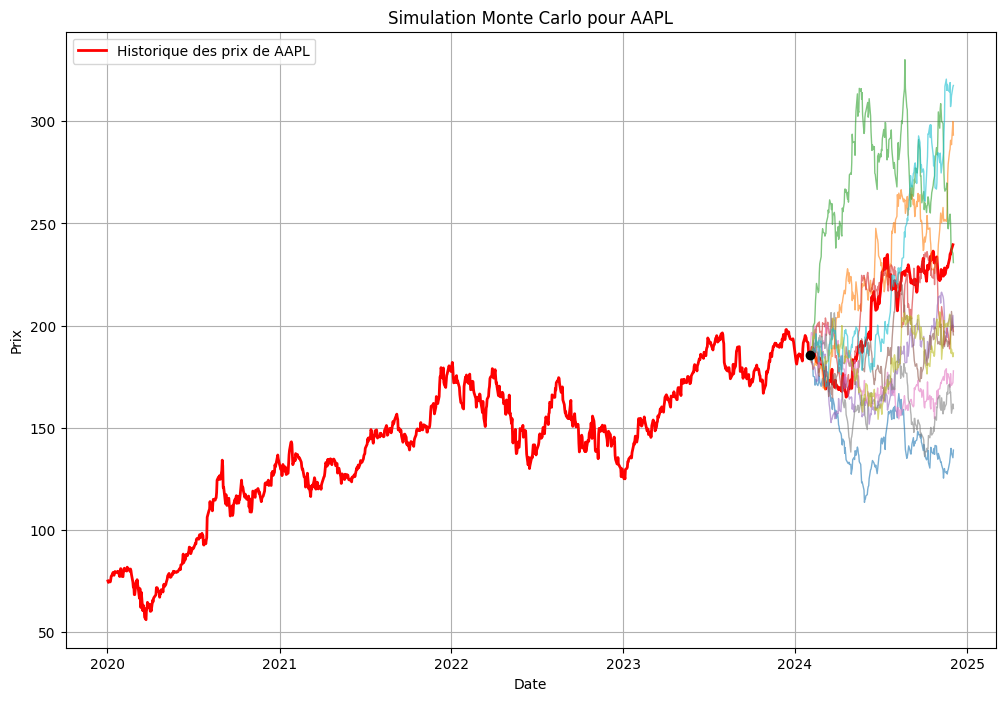

Le prix équitable estimé est de 226.67


In [72]:
# Lancer la simulation
fair_price = MonteCarloSimulation(ticker, prices, nb_simulation, nb_days_simulation, start_date_simulation, start_price_simulation, mean_return, std_return, risk_free_rate)
print(f"Le prix équitable estimé est de {round(fair_price, 2)}")